Урок 6. Сегментация
---

**Домашнее задание**:
Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?

**Сначала нужно было подготовить данные**:
1. Получить разметку по цветам для всех классов с изображения (можно в любом редакторе изображений с помощью инструмента пипетка)
2. Создать столько каналов с бинарными масками, сколько есть классов в разметке
3. Если будете пользоваться предобученной моделью, то прогнать изображения через нужный препроцессинг данных

И последний слой юнета должен тоже содержать столько каналов, сколько классов есть в разметке. Размерность выходного слоя юнета - (None, 256, 256, кол-во классов).

# Установка нужных библиотек и работа с датасетом

**How to use kaggle data within Google Colab**:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

1) `!pip install -q kaggle`

2) `from google.colab import files`

`files.upload()`

Choose the kaggle.json file that you downloaded

3) `!mkdir ~/.kaggle`

`!cp kaggle.json ~/.kaggle/`

Make directory named kaggle and copy kaggle.json file there.

4) `!chmod 600 ~/.kaggle/kaggle.json`

Change the permissions of the file.

5) `!kaggle datasets list`

- That's all ! You can check if everything's okay by running this command.

**Download Data**

`!kaggle competitions download -c 'name-of-competition'`

У меня сработало:

`!kaggle datasets download -d 'dansbecker/cityscapes-image-pairs'`

Use unzip command to unzip the data:

For example,

Create a directory named train,

`!mkdir train`

unzip train data there,

`!unzip train.zip -d train`

In [ ]:
# !pip install opencv-python

In [ ]:
# !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle datasets download -d 'dansbecker/cityscapes-image-pairs'
!unzip cityscapes-image-pairs.zip -d cityscapes-image-pairs
!rm -R cityscapes-image-pairs/cityscapes_data/cityscapes_data/
!mv cityscapes-image-pairs/cityscapes_data/train cityscapes-image-pairs
!mv cityscapes-image-pairs/cityscapes_data/val cityscapes-image-pairs
!rm -R cityscapes-image-pairs/cityscapes_data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes-image-pairs/cityscapes_data/cityscapes_data/train/2763.jpg 

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras
from keras.layers.normalization import BatchNormalization
from keras.layers import (Input, Dense, Dropout, Activation, Flatten, Convolution2D,
                          MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate)
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, model_from_json, load_model
from keras.regularizers import l2
from keras.preprocessing import image
from keras.optimizers import Adam

The file /content/cityscapes-image-pairs/train/ does not exist.
(256, 512, 3)
2975


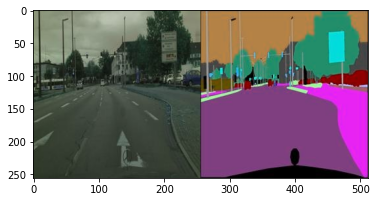

In [ ]:
path = '/content/cityscapes-image-pairs/train/'
if os.path.isfile(path):
    img1 = cv2.imread(path, 0)
else:
    print ("The file " + path + " does not exist.")

flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
plt.imshow(img0)
print(np.shape(img0))
print(len(flist))

In [ ]:
# чтение картинок и создание тренировочного датасета
szy, szx, _ = np.shape(img0)
N_ex = 500 # берём часть датасета, чтобы нейронке хватило памяти
N_bias = 0
x_train = np.zeros((N_ex, szy, int(szx/2), 3))
y_train = np.zeros((N_ex, szy, int(szx/2), 3))
k = 0

for f in flist[N_bias:N_bias+N_ex]:
    x_train[k] = cv2.imread(path+f)[:,:256]/256
    y_train[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

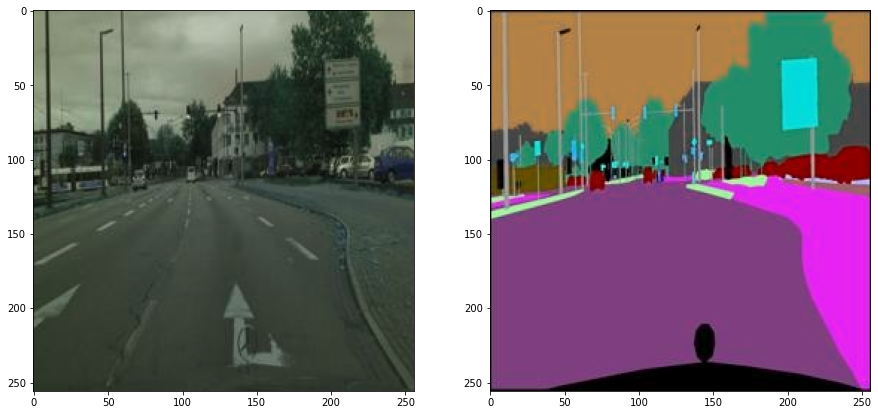

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(y_train[0]);

In [ ]:
# то же самое для тренировочных данных
path = '/content/cityscapes-image-pairs/val/'

if os.path.isfile(path):
    img1 = cv2.imread(path, 0)
else:
    print ("The file " + path + " does not exist.")

flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
N_val = 50  # берём часть датасета, чтобы нейронке хватило памяти

szy,szx,_ = np.shape(img0)
x_val = np.zeros((N_val,szy,int(szx/2),3))
y_val = np.zeros((N_val,szy,int(szx/2),3))
k = 0;

for f in flist[0:N_val]:
    x_val[k] = cv2.imread(path+f)[:,:256]/256
    y_val[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

The file /content/cityscapes-image-pairs/val/ does not exist.


# Вариант Unet 1

In [ ]:
import keras.backend as K
# функции нужно писать не на Numpy, а на бекэнде, на котором запущен keras, в данном случае на TensorFlow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [ ]:
#u-net architecture

# define conv_factory: batch normalization + ReLU + Conv2D + Dropout (optional)
def conv_factory(x, concat_axis, nb_filter,
                 dropout_rate=None, weight_decay=1E-4):
    x = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (5, 5), dilation_rate=(2, 2),
               kernel_initializer="he_uniform",
               padding="same",
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


# define dense block: a nb_layers stack of conv_factory layers merged together
def denseblock(x, concat_axis, nb_layers, growth_rate, dropout_rate=None, weight_decay=1E-4):
    list_feat = [x]
    for i in range(nb_layers):
        x = conv_factory(x, concat_axis, growth_rate,dropout_rate, weight_decay)
        list_feat.append(x)
    x = Concatenate(axis=concat_axis)(list_feat)

    return x


# define model U-net modified with dense block
def u_net():
    dr = 0.5
    nr = 2
    mod_inputs = Input((256,256,3))
    print("inputs shape:", mod_inputs.shape) #input layer

    conv1 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mod_inputs)
    print("conv1 shape:", conv1.shape)
    db1 = denseblock(x=conv1, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db1 shape:", db1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    print("pool1 shape:", pool1.shape)

    conv2 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    print("conv2 shape:", conv2.shape)
    db2 = denseblock(x=conv2, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db2 shape:", db2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    print("pool2 shape:", pool2.shape)

    conv3 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    print("conv3 shape:", conv3.shape)
    db3 = denseblock(x=conv3, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db3 shape:", db3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    print("pool3 shape:", pool3.shape)

    conv4 = Conv2D(512/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    print("conv4 shape:", conv4.shape)
    db4 = denseblock(x=conv4, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db4 shape:", db4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    print("pool4 shape:", pool4.shape)
#################this is the bottleneck######################################
    conv5 = Conv2D(1024/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    print("conv5 shape:", conv5.shape)
    db5 = denseblock(x=conv5, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db5.shape)
    up5 = Conv2D(512/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db5))
    print("up5 shape:", up5.shape)
    merge5 = Concatenate(axis=3)([ BatchNormalization()(db4), BatchNormalization()( up5)]) #skip connection db4 to up5
    print("merge5 shape:", merge5.shape)

    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    print("conv6 shape:", conv6.shape)
    db6 = denseblock(x=conv6, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db6.shape)
    up6 = Conv2D(256/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db6))
    print("up6 shape:", up6.shape)
    merge6 = Concatenate(axis=3)([BatchNormalization()(db3), BatchNormalization()(up6)]) #skip connection db3 to up6
    print("merge6 shape:", merge6.shape)

    conv7 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    print("conv7 shape:", conv7.shape)
    db7 = denseblock(x=conv7, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db7 shape:", db7.shape)
    up7 = Conv2D(128/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db7))
    print("up7 shape:", up7.shape)
    merge7 = Concatenate(axis=3)([BatchNormalization()(db2), BatchNormalization()(up7)]) #skip connection db2 to up7
    print("merge7 shape:", merge7.shape)

    conv8 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    print("conv8 shape:", conv8.shape)
    db8 = denseblock(x=conv8, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db8 shape:", db8.shape)
    up8 = Conv2D(64/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db8))
    print("up8 shape:", up8.shape)
    merge8 = Concatenate(axis=3)([BatchNormalization()(db1), BatchNormalization()(up8)]) #skip connection db1 to up8
    print("merge8 shape:", merge8.shape)

    conv9 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    print("conv9 shape:", conv9.shape)
    db9 = denseblock(x=conv9, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db9 shape:", db9.shape)
    conv10 = Conv2D(32/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db9) # final node layer
    print("conv10 shape:", conv10.shape)
    conv11 = Conv2D(3, 1, activation='sigmoid')(conv10)  #output layer matched in size with the input
    print("conv11 shape:", conv11.shape)

    model = Model(inputs=mod_inputs, outputs=conv11)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[dice_coef],           # самописная метрика dice
                  )
    return model

In [ ]:
model = u_net()

inputs shape: (None, 256, 256, 3)
conv1 shape: (None, 256, 256, 32)
db1 shape: (None, 256, 256, 96)
pool1 shape: (None, 128, 128, 96)
conv2 shape: (None, 128, 128, 64)
db2 shape: (None, 128, 128, 128)
pool2 shape: (None, 64, 64, 128)
conv3 shape: (None, 64, 64, 128)
db3 shape: (None, 64, 64, 192)
pool3 shape: (None, 32, 32, 192)
conv4 shape: (None, 32, 32, 256)
db4 shape: (None, 32, 32, 320)
pool4 shape: (None, 16, 16, 320)
conv5 shape: (None, 16, 16, 512)
db5 shape: (None, 16, 16, 560)
up5 shape: (None, 32, 32, 256)
merge5 shape: (None, 32, 32, 576)
conv6 shape: (None, 32, 32, 512)
db5 shape: (None, 32, 32, 560)
up6 shape: (None, 64, 64, 128)
merge6 shape: (None, 64, 64, 320)
conv7 shape: (None, 64, 64, 128)
db7 shape: (None, 64, 64, 160)
up7 shape: (None, 128, 128, 64)
merge7 shape: (None, 128, 128, 192)
conv8 shape: (None, 128, 128, 64)
db8 shape: (None, 128, 128, 96)
up8 shape: (None, 256, 256, 32)
merge8 shape: (None, 256, 256, 128)
conv9 shape: (None, 256, 256, 32)
db9 shape: (No

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 32) 128         conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 256, 256, 32) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [ ]:
hist = model.fit(x_train, y_train, epochs=50, shuffle = True, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/50
50/50 [==============================] - 45s 671ms/step - loss: 1.6249 - dice_coef: 0.4506 - val_loss: 62.0190 - val_dice_coef: 0.2304
Epoch 2/50
50/50 [==============================] - 30s 608ms/step - loss: 3.9420 - dice_coef: 0.5005 - val_loss: 78.2607 - val_dice_coef: 0.4806
Epoch 3/50
50/50 [==============================] - 30s 610ms/step - loss: 12.2498 - dice_coef: 0.5114 - val_loss: 90.4715 - val_dice_coef: 0.4714
Epoch 4/50
50/50 [==============================] - 31s 625ms/step - loss: 21.4399 - dice_coef: 0.5174 - val_loss: 50.4767 - val_dice_coef: 0.4369
Epoch 5/50
50/50 [==============================] - 32s 632ms/step - loss: 32.3685 - dice_coef: 0.5176 - val_loss: 73.8773 - val_dice_coef: 0.2512
Epoch 6/50
50/50 [==============================] - 32s 631ms/step - loss: 51.6115 - dice_coef: 0.5160 - val_loss: 109.1824 - val_dice_coef: 0.3618
Epoch 7/50
50/50 [==============================] - 32s 638ms/step - loss: 78.9328 - dice_coef: 0.5173 - val_loss: 236.

In [ ]:
hist.history

{'dice_coef': [0.47913023829460144,
  0.5034844875335693,
  0.515038251876831,
  0.5196067690849304,
  0.5165941715240479,
  0.5163379907608032,
  0.5180907249450684,
  0.5203248858451843,
  0.5233001708984375,
  0.5229314565658569,
  0.5239030718803406,
  0.5260981917381287,
  0.5275375247001648,
  0.5288218855857849,
  0.5286911129951477,
  0.5286558270454407,
  0.5316979885101318,
  0.5302432775497437,
  0.530997097492218,
  0.5333369970321655,
  0.5344936847686768,
  0.535660982131958,
  0.5359780788421631,
  0.5364021062850952,
  0.5361294746398926,
  0.5380474925041199,
  0.5383830070495605,
  0.5403729677200317,
  0.539865255355835,
  0.5398861169815063,
  0.541149377822876,
  0.5403937697410583,
  0.5409209728240967,
  0.5407772064208984,
  0.5413168668746948,
  0.5425553321838379,
  0.543332576751709,
  0.5425150990486145,
  0.5425006151199341,
  0.542086660861969,
  0.5434762239456177,
  0.542725145816803,
  0.5435024499893188,
  0.5449608564376831,
  0.5455814003944397,
  0.

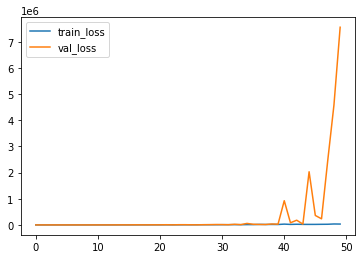

In [ ]:
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

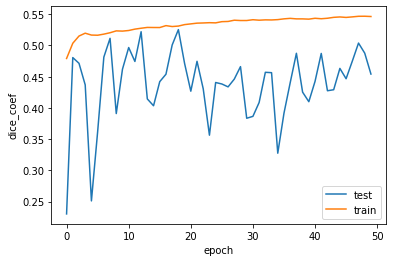

In [ ]:
plt.plot(hist.history['val_dice_coef'], label='test')
plt.plot(hist.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [ ]:
pred = model.predict(x_val)
print(pred.shape)

(50, 256, 256, 3)


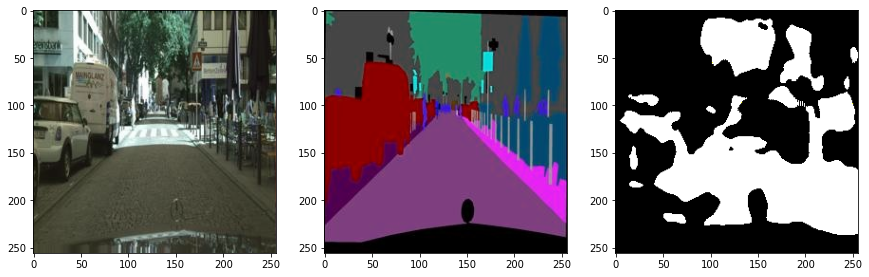

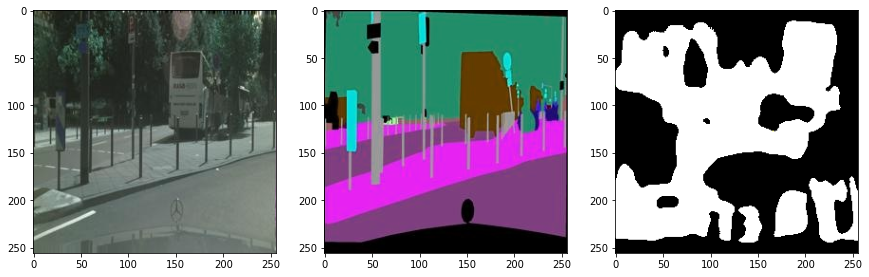

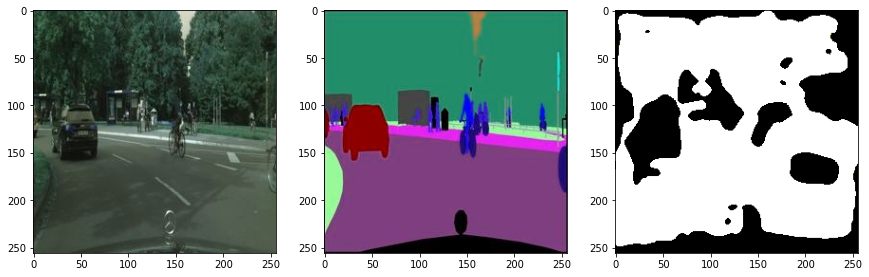

In [ ]:
ni = 3
for k in range(ni):
    plt.figure(figsize=(20,60))

    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])

    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])

    plt.subplot(ni,4,3+k*4)
    plt.imshow(pred[k])

(1, 256, 256)


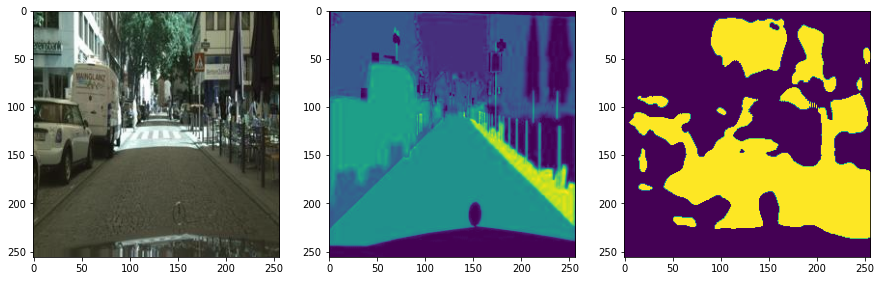

In [ ]:
def show_predictions(model):

    sample_image = x_val[0]
    sample_mask = y_val[0]

    pred_mask = model.predict(sample_image[None])[..., 0] # нулевой канал, можно любой (можно которого больше)
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image) # картинка
    ax[1].imshow(sample_mask[..., 0]) # истиная маска
    ax[2].imshow(np.squeeze(pred_mask, axis=0)) # предсказаная маска
    plt.show()

# исходная картинка, истинная маска, предсказанная маска
show_predictions(model)

# Вариант Unet 2

In [ ]:
def Unet(num_classes=14, input_shape=(256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # в Unet основной посыл в том, тобы прокидывать признаки в конец сетки,
    # когда уже идёт предсказание маски. Поэтому мы запоминаем этот слой и прокидываем его в конец
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)


    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # начинаем растягивать картинку
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # конкатенируем то что получили после 3-го увеличения и блок 3
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор (14 классов, поэтому softmax)
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

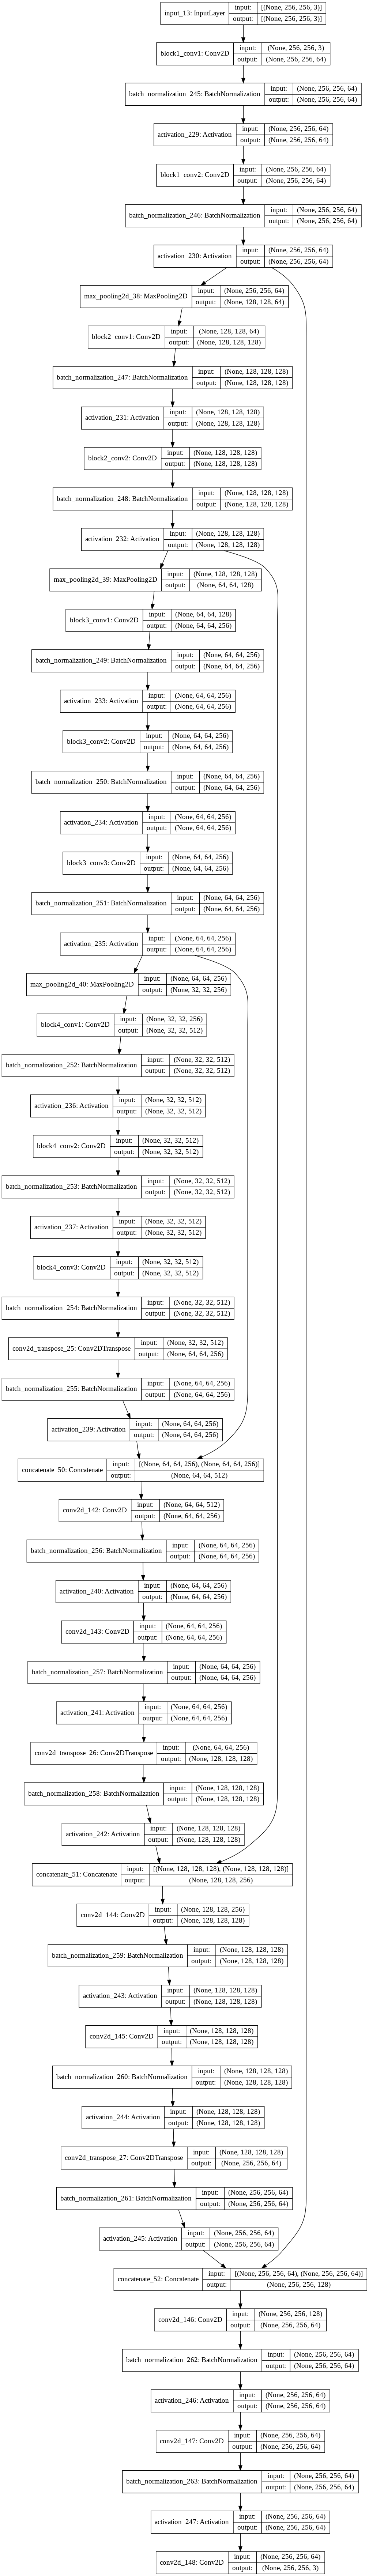

In [ ]:
model_1 = Unet(3, (256, 256, 3))

plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [ ]:
model_1.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef]) # самописная метрика dice
model_1.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_245 (BatchN (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_229 (Activation)     (None, 256, 256, 64) 0           batch_normalization_245[0][0]    
____________________________________________________________________________________________

In [ ]:
history_1 = model_1.fit(x_train, y_train,
                      epochs=20,
                      batch_size=10,
                      validation_data=(x_val, y_val),
                      )

Epoch 1/20
50/50 [==============================] - 38s 571ms/step - loss: 1.1809 - dice_coef: 0.3610 - val_loss: 1.9008 - val_dice_coef: 0.3320
Epoch 2/20
50/50 [==============================] - 28s 556ms/step - loss: 1.1379 - dice_coef: 0.3599 - val_loss: 1.6809 - val_dice_coef: 0.3611
Epoch 3/20
50/50 [==============================] - 28s 559ms/step - loss: 1.1398 - dice_coef: 0.3610 - val_loss: 1.1350 - val_dice_coef: 0.3459
Epoch 4/20
50/50 [==============================] - 29s 574ms/step - loss: 1.1442 - dice_coef: 0.3603 - val_loss: 1.3388 - val_dice_coef: 0.3556
Epoch 5/20
50/50 [==============================] - 29s 581ms/step - loss: 1.1492 - dice_coef: 0.3646 - val_loss: 1.2497 - val_dice_coef: 0.3550
Epoch 6/20
50/50 [==============================] - 29s 585ms/step - loss: 1.1372 - dice_coef: 0.3608 - val_loss: 1.4058 - val_dice_coef: 0.3628
Epoch 7/20
50/50 [==============================] - 30s 593ms/step - loss: 1.1436 - dice_coef: 0.3630 - val_loss: 1.1629 - val_dic

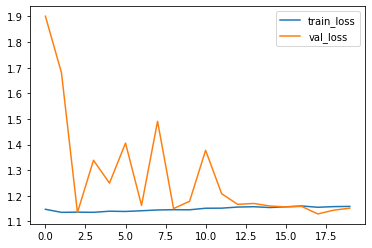

In [ ]:
plt.plot(history_1.history['loss'], label='train_loss')
plt.plot(history_1.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

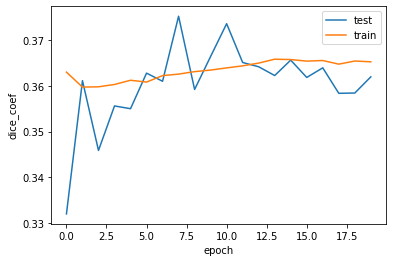

In [ ]:
plt.plot(history_1.history['val_dice_coef'], label='test')
plt.plot(history_1.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [ ]:
pred_1 = model_1.predict(x_val)
print(pred_1.shape)

(50, 256, 256, 3)


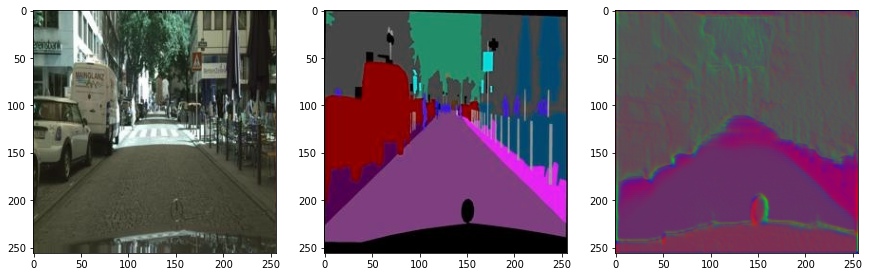

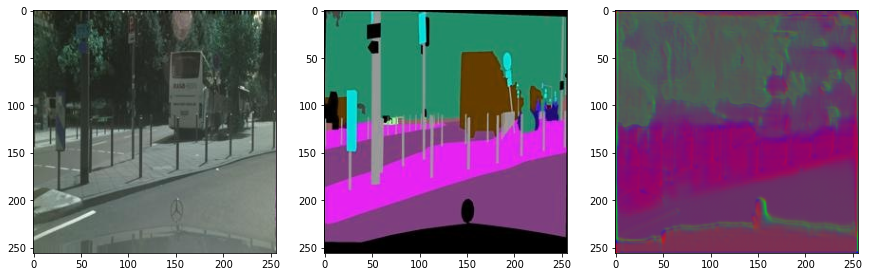

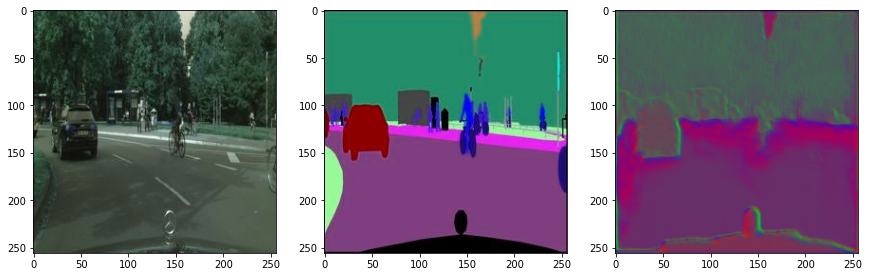

In [ ]:
ni = 3
for k in range(ni):
    plt.figure(figsize=(20,60))

    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])

    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])

    plt.subplot(ni,4,3+k*4)
    plt.imshow(pred_1[k])

(1, 256, 256)


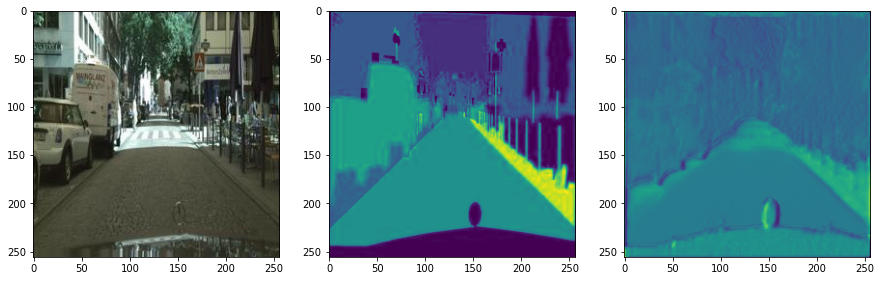

In [ ]:
def show_predictions(model):

    sample_image = x_val[0]
    sample_mask = y_val[0]

    pred_mask = model.predict(sample_image[None])[..., 0] # нулевой канал, можно любой (можно которого больше)
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image) # картинка
    ax[1].imshow(sample_mask[..., 0]) # истиная маска
    ax[2].imshow(np.squeeze(pred_mask, axis=0)) # предсказаная маска
    plt.show()

# исходная картинка, истинная маска, предсказанная маска
show_predictions(model_1)

# Вывод

Улучшить качество обучения помогает архитектура сети и количество эпох обучения: больше - лучше.